In [1]:
!pip install transformers
!pip install shap
!pip install spicy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 79.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 27.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import transformers
import shap
import spicy as sp
from transformers import AutoModel, AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.utils import data
from sklearn import metrics
import torch.nn as nn
import pandas as pd
import numpy as np
import argparse
import logging
import random
import torch
import sys
import os

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
PREDICTION_COLUMN = 'Нейротизм_3'
model_path = '/content/drive/MyDrive/big_5/OCEAN_shap_texts_bert/simple_bert_Нейротизм_3_43375.bin'

dataset = pd.read_csv('/content/drive/MyDrive/big_5/df_texts_ocean.csv')
dataset['lengths'] = dataset.post_text.apply(lambda x: len(str(x).split()))
dataset = dataset.query('30 > lengths > 15')
data = pd.DataFrame({'text_raw':dataset['post_text'],'text':dataset['post_text_preprocessed'],'target':dataset[PREDICTION_COLUMN]})
#data = data.query('target in [0,2]').sample(5000)
_,data = train_test_split(data, test_size=0.3, stratify=data.target)
data

,text_raw,text,target
247464,С днем защитника Отечества! Сегодня каждый мож...,с днем защитника отечества PUNK сегодня каждый...,1
33993,"Улечка, С Днем Рождения тебя! 😚Всего всего все...",улечка PUNK с днем рождения тебя PUNK EMOJI вс...,2
204371,Поздравляю с 14 Февраля! И пусть этот день в л...,поздравляю с NUM февраля PUNK и пусть этот ден...,2
105595,ахахха))))))))))))))вот ты вреднааая))))))))))...,ахахха EMOJI PUNK вот ты вреднааая EMOJI PUNK ...,2
26748,Канал им. Москвы #русь #природа #поле #закат #...,канал им PUNK москвы русь природа поле закат н...,0
...,...,...,...
126493,"Lords Mobile ещё круче, чем я себе представлял...",lords mobile ещё круче PUNK чем я себе предста...,1
244967,Не могу продолжить кругосветное путешествие в ...,не могу продолжить кругосветное путешествие в ...,2
191788,Каждый день радует!!!))) а Вы сомневайтесь дал...,каждый день радует PUNK PUNK PUNK EMOJI PUNK а...,2
126469,"Lords Mobile ещё круче, чем я себе представлял...",lords mobile ещё круче PUNK чем я себе предста...,1


In [5]:
data.target.value_counts()

2    2934
1    2421
0    1564
Name: target, dtype: int64

In [6]:
len(data)

6919

In [7]:
frames = []
classes = data.target.unique()

for i in classes:
    g = data[data.target == i].sample(1500)
    frames.append(g)

equally_sampled = pd.concat(frames)

In [8]:
equally_sampled

,text_raw,text,target
53929,"Еще одно поздравление!Василиса, ты отзывчивая,...",еще одно поздравление PUNK василиса PUNK ты от...,1
220045,"Танюшка обязательно посмотри мои видеозаписи, ...",танюшка обязательно посмотри мои видеозаписи P...,1
30082,"Можете сказать ""нет"", даже если сильно хочетс...",можете сказать нет PUNK даже если сильно хочет...,1
130816,Сказать Спасибо! отправителю:vkontakte.ru/app1...,сказать спасибо PUNK отправителю PUNK vkontakt...,1
7588,Почему?это же так весело)))Если хочешь её разб...,почему PUNK это же так весело EMOJI PUNK если ...,1
...,...,...,...
27962,Я оценил городскую новинку «Продолжается набор...,я оценил городскую новинку PUNK продолжается н...,0
69478,"Синдром выгорания, Водопьянова Н.Е.( MBI) Опро...",синдром выгорания PUNK водопьянова н PUNK е PU...,0
26588,"Почти спустился когда уже, всё умиротворенное ...",почти спустился когда уже PUNK всё умиротворен...,0
13332,Нужен профессиональный фотограф на 28 мая к 16...,нужен профессиональный фотограф на NUM мая к N...,0


In [9]:
class Bert_sequence_classifcation(nn.Module):
    def __init__(self, model_name, num_classes):
        super(Bert_sequence_classifcation, self).__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=num_classes)

    def forward(self, input_ids, attention_mask):
        # Feed input to BERT
        logits = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask, return_dict=True).logits 
        return logits

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
 # load the model and tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained('xlm-roberta-base')
model = Bert_sequence_classifcation('xlm-roberta-base', 3).to(device)
model.load_state_dict(torch.load(model_path))   #,map_location=torch.device('cpu')))
labels = sorted(model.bert.config.label2id, key=model.bert.config.label2id.get)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

In [12]:
def f(x):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # print(x)
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=100, truncation=True) for v in x], device=device)
    # print(tv)
    attention_mask = (tv != 0).type(torch.int64)
    # print(attention_mask)
    outputs = model(tv, attention_mask).detach().cpu()
    outputs = torch.log_softmax(outputs, dim=1).numpy()
    # print(outputs)
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    return val

In [13]:
def predict(x):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # print(x)
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=100, truncation=True) for v in x], device=device)
    # print(tv)
    attention_mask = (tv != 0).type(torch.int64).to(device)
    # print(attention_mask)
    outputs = model(tv, attention_mask).detach().cpu()
    res = torch.log_softmax(outputs, dim=1).argmax(dim=1)
    return res

In [14]:
predict(['приветик','еще раз привет'])

tensor([1, 1])

In [15]:
data = equally_sampled

In [16]:
texts = list(data.text)
targets = list(data.target)

def chunkify(texts, targets, n):

  texts_splited = [texts[i::n] for i in range(n)]
  targets_splited = [targets[i::n] for i in range(n)]

  return texts_splited, targets_splited

texts_splited, targets_splited =chunkify(texts, targets, 100)

In [17]:
len(texts_splited[0])

45

In [18]:
from tqdm.auto import tqdm

In [19]:
predictions = []
for text in tqdm(texts_splited):
  predictions.append(predict(text))

  0%|          | 0/100 [00:00<?, ?it/s]

In [20]:
list_predictions = []
for i in predictions:
  for x in list(i):
    list_predictions.append(int(x))

In [21]:
len(list_predictions)

4500

In [22]:
data['predictions'] = list_predictions
data.head()

,text_raw,text,target,predictions
53929,"Еще одно поздравление!Василиса, ты отзывчивая,...",еще одно поздравление PUNK василиса PUNK ты от...,1,0
220045,"Танюшка обязательно посмотри мои видеозаписи, ...",танюшка обязательно посмотри мои видеозаписи P...,1,0
30082,"Можете сказать ""нет"", даже если сильно хочетс...",можете сказать нет PUNK даже если сильно хочет...,1,1
130816,Сказать Спасибо! отправителю:vkontakte.ru/app1...,сказать спасибо PUNK отправителю PUNK vkontakt...,1,1
7588,Почему?это же так весело)))Если хочешь её разб...,почему PUNK это же так весело EMOJI PUNK если ...,1,0


In [23]:
polar_people = data.query('target == predictions')
polar_people

,text_raw,text,target,predictions
30082,"Можете сказать ""нет"", даже если сильно хочетс...",можете сказать нет PUNK даже если сильно хочет...,1,1
130816,Сказать Спасибо! отправителю:vkontakte.ru/app1...,сказать спасибо PUNK отправителю PUNK vkontakt...,1,1
235903,"И как же я Тебя называла?? Ах, точно!! Ты же г...",и как же я тебя называла PUNK PUNK ах PUNK точ...,1,1
220086,"...лежать на песочном пляжу средиземного моря,...",PUNK PUNK PUNK лежать на песочном пляжу среди...,1,1
145265,Гы)))) Я сама себе плюшку принесла ;) Я на это...,гы EMOJI PUNK я сама себе плюшку принесла PUNK...,1,1
...,...,...,...,...
10475,Я оценил городскую новинку «На портале «Узнай ...,я оценил городскую новинку PUNK на портале PUN...,0,0
12372,Готов ли ты заниматься этим через 5-10 лет? 🤔О...,готов ли ты заниматься этим через NUM PUNK NUM...,0,0
26037,#котэ #котывезде #плюшка#вислоухий #кот #кошка...,котэ котывезде плюшка вислоухий кот кошка HAS...,0,0
243009,готовы предложить:Широкий спектр производимой ...,готовы предложить PUNK широкий спектр производ...,0,0


In [24]:
polar_people.target.value_counts()

1    856
2    467
0    120
Name: target, dtype: int64

In [25]:
polar_people = polar_people.sort_values(by=['target'])
polar_people

,text_raw,text,target,predictions
13332,Нужен профессиональный фотограф на 28 мая к 16...,нужен профессиональный фотограф на NUM мая к N...,0,0
196261,Как хорошо что в моей жизни есть такие люди!!!...,как хорошо что в моей жизни есть такие люди PU...,0,0
186291,Тебе скучно? Скорее заходи в “Интерн: 3 в ряд”...,тебе скучно PUNK скорее заходи в PUNK интерн P...,0,0
180983,"с 8 марта даже если ты уже спишь,мой друг прел...",с NUM марта даже если ты уже спишь PUNK мой др...,0,0
237675,"Я узнала, что кто-то из друзей тебя любит! Узн...",я узнала PUNK что кто PUNK то из друзей тебя л...,0,0
...,...,...,...,...
168504,Корм для питомца — вот что мне сейчас необходи...,корм для питомца PUNK вот что мне сейчас необх...,2,2
16531,"Иришка, поздравляю тебя с Новым годом!!!!!Пуст...",иришка PUNK поздравляю тебя с новым годом PUNK...,2,2
234664,"Ура! За окном зима, а значит и в Родине наступ...",ура PUNK за окном зима PUNK а значит и в родин...,2,2
235447,Ура! Я уже на 14 уровне в Проклятии Часовщика....,ура PUNK я уже на NUM уровне в проклятии часов...,2,2


In [26]:
s = 'новым годом с наступающим год лошади'
for i, row in polar_people.iterrows():
  if s in row.text:
    print(row)

text_raw       С Новым годом С наступающим Год лошади 2014 По...
text           с новым годом с наступающим год лошади NUM поз...
target                                                         1
predictions                                                    1
Name: 246028, dtype: object
text_raw       С Новым годом С наступающим Год лошади 2014 По...
text           с новым годом с наступающим год лошади NUM поз...
target                                                         1
predictions                                                    1
Name: 34780, dtype: object
text_raw       С Новым годом С наступающим Год лошади 2014 По...
text           с новым годом с наступающим год лошади NUM поз...
target                                                         1
predictions                                                    1
Name: 214706, dtype: object
text_raw       С Новым годом С наступающим Год лошади 2014 По...
text           с новым годом с наступающим год лошади NUM поз...
target 

In [27]:
import shap
explainer = shap.Explainer(f, tokenizer, output_names=labels)

In [ ]:
texts = list(polar_people.text)
shap_values = explainer(texts)

Partition explainer:  19%|█▉        | 281/1443 [15:42<1:05:13,  3.37s/it]Token indices sequence length is longer than the specified maximum sequence length for this model (2130 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  87%|████████▋ | 1254/1443 [1:10:41<10:39,  3.38s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  98%|█████████▊| 1417/1443 [1:20:21<01:29,  3.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 1444it [1:22:02,  3.42s/it]


In [ ]:
shap.plots.text(shap_values[:10]) # низкий уровень по шкале

In [ ]:
shap.plots.text(shap_values[10:20]) # низкий уровень по шкале

In [ ]:
shap.plots.text(shap_values[20:30]) # низкий уровень по шкале

In [ ]:
shap.plots.text(shap_values[30:40]) # низкий уровень по шкале

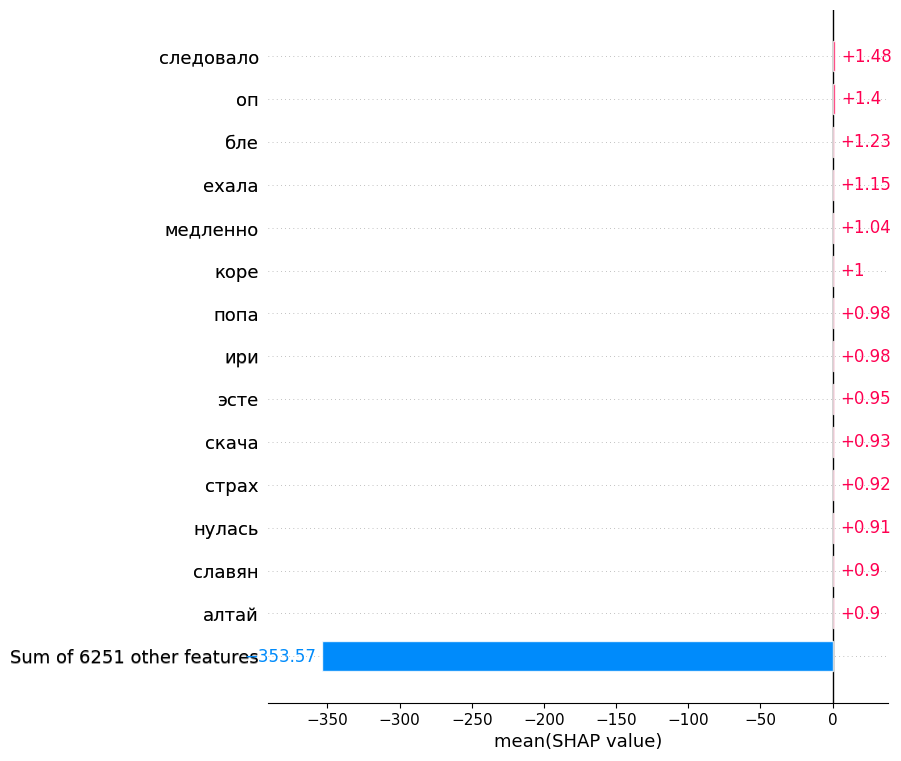

In [ ]:

shap.plots.bar(shap_values[:,:, 2].mean(axis=0), max_display=15,
               order=shap.Explanation.argsort.flip)

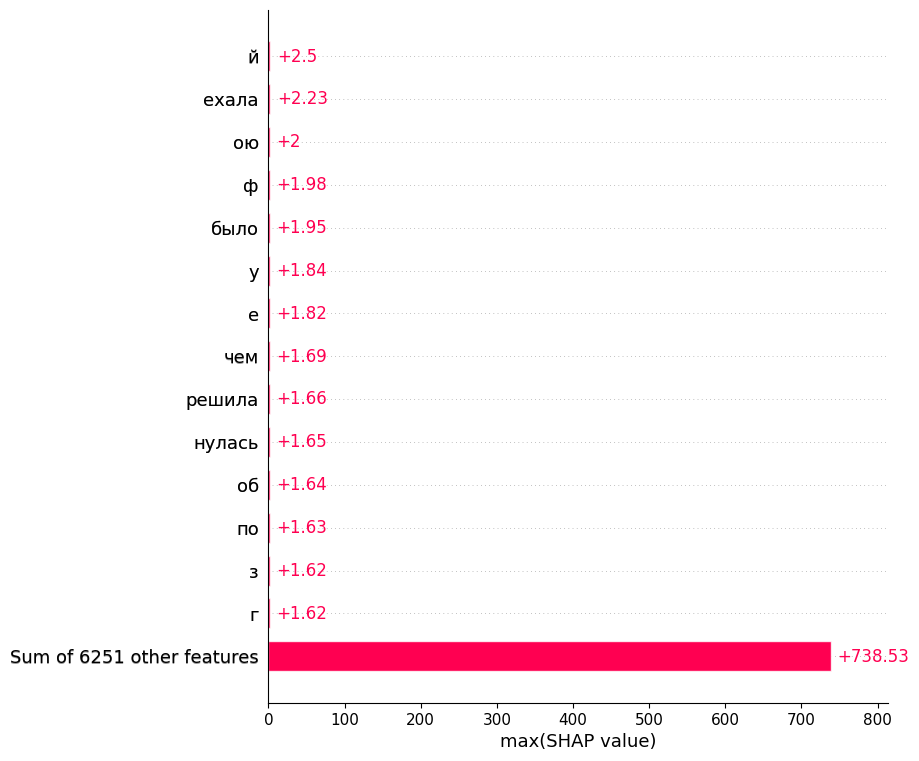

In [ ]:

shap.plots.bar(shap_values[:,:, 2].max(axis=0), max_display=15,
               order=shap.Explanation.argsort.flip)

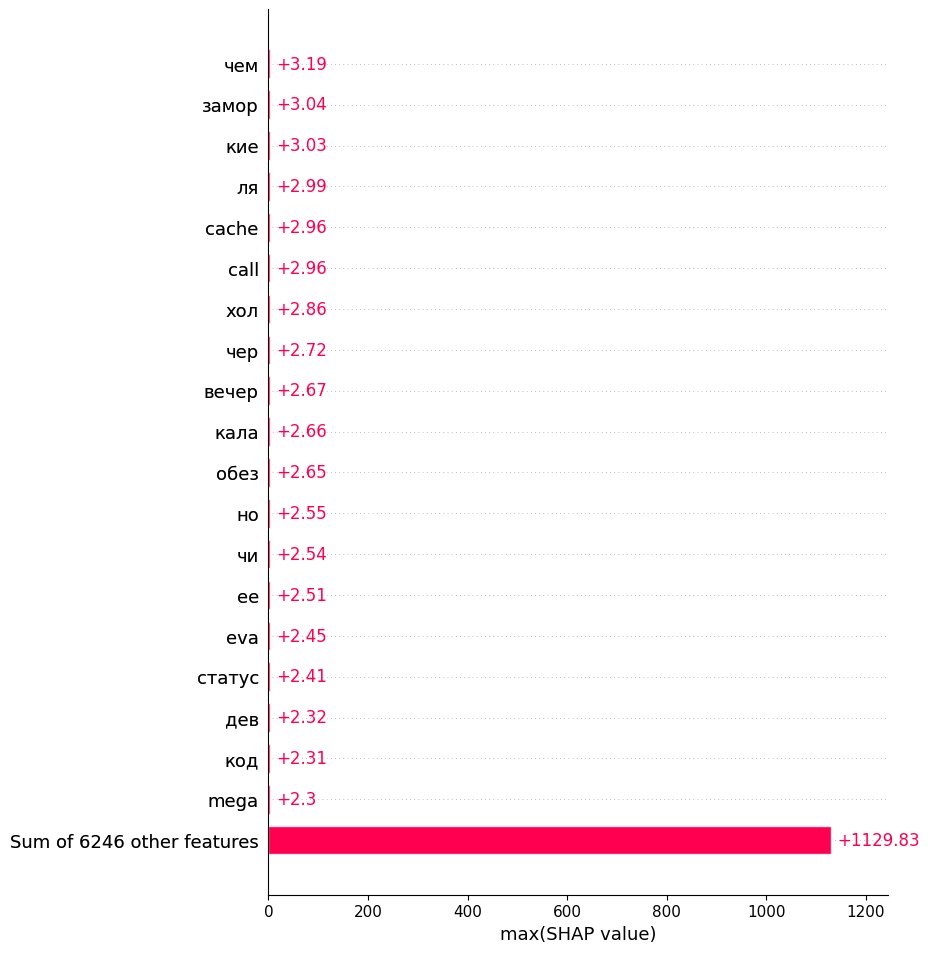

In [ ]:

shap.plots.bar(shap_values[:,:, 0].max(axis=0), max_display=20,
               order=shap.Explanation.argsort.flip)

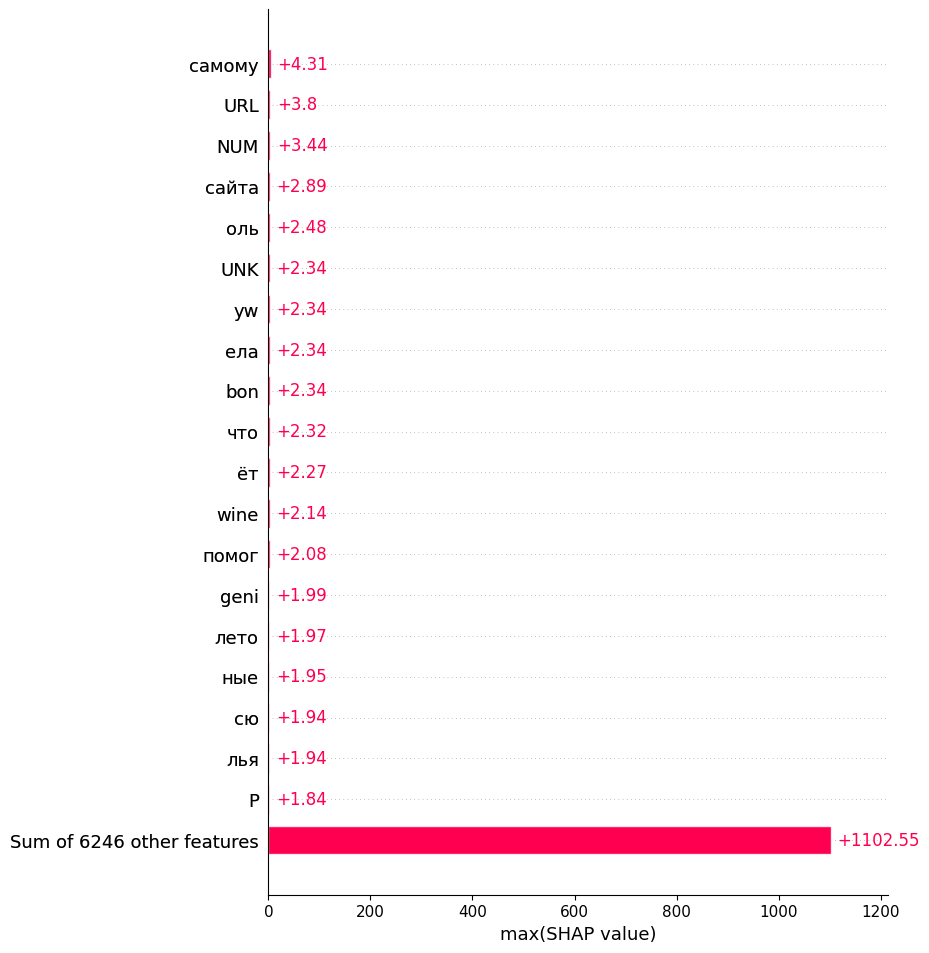

In [ ]:

shap.plots.bar(shap_values[:,:, 1].max(axis=0), max_display=20,
               order=shap.Explanation.argsort.flip)

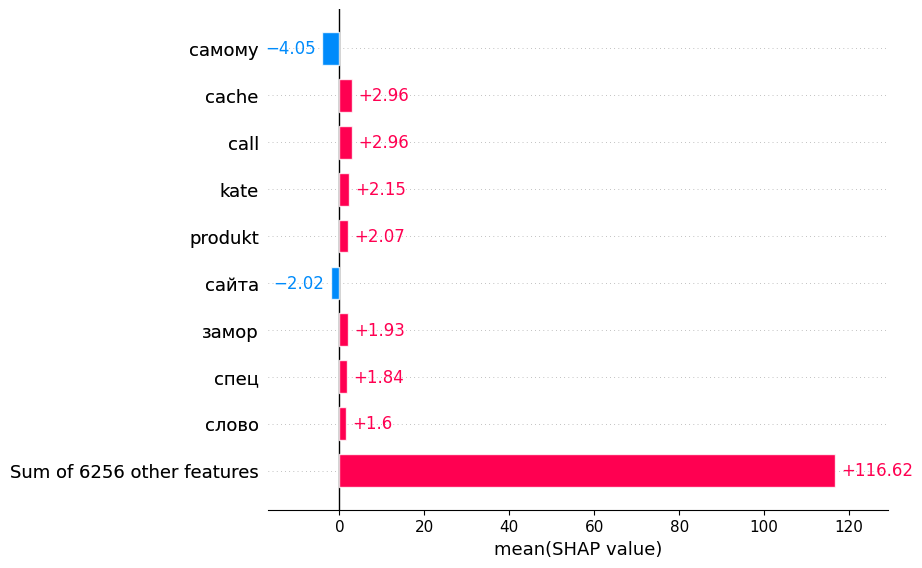

In [ ]:
shap.plots.bar(shap_values[:,:,0].mean(0)) # по классу 0

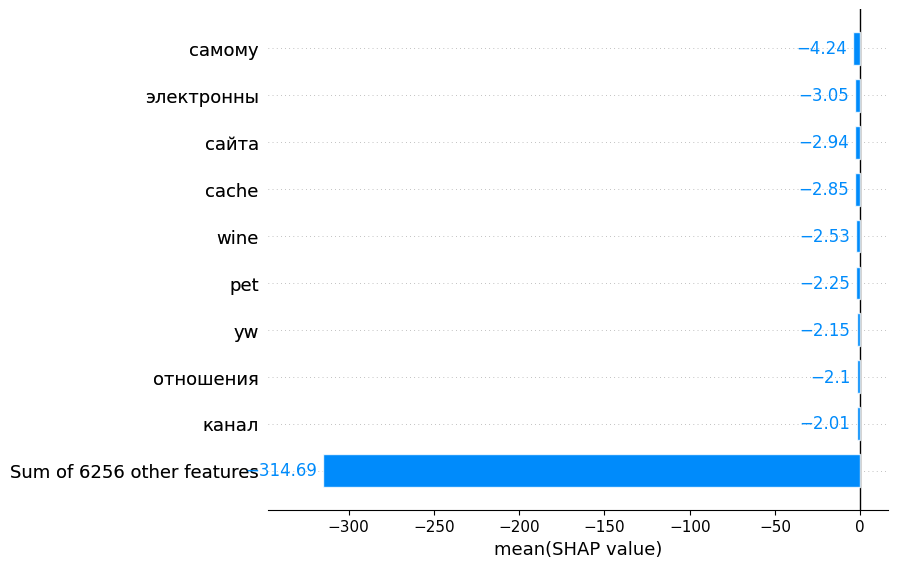

In [ ]:
shap.plots.bar(shap_values[:,:,2].mean(0)) 

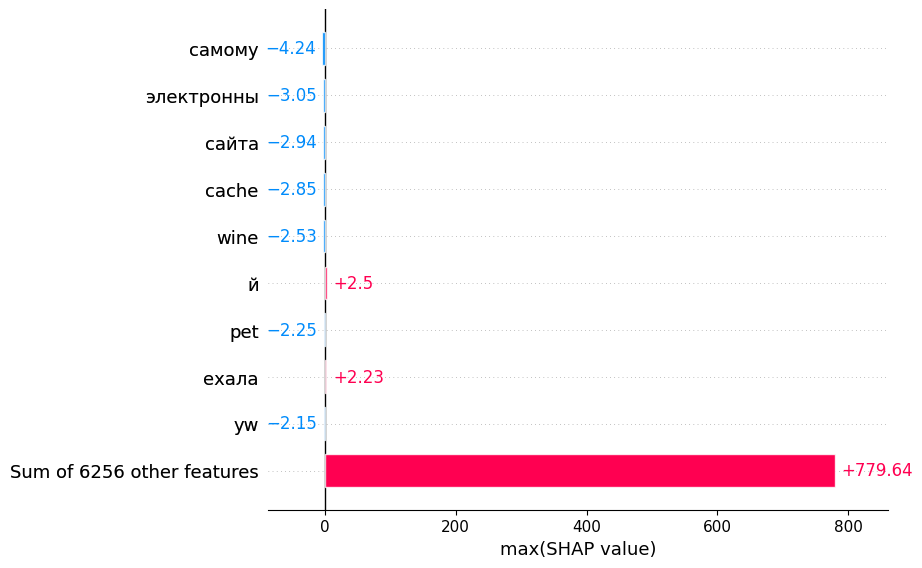

In [ ]:
shap.plots.bar(shap_values[:,:,2].max(0)) 

In [ ]:
shap.plots.bar(shap_values[2,:, 2], max_display=15,
               order=shap.Explanation.argsort.flip)

In [ ]:
shap.waterfall_plot(shap_values[2][:, 2], max_display=15)